[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1884
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 18
[LightGBM] [Info] Start training from score -1.051545
[LightGBM] [Info] Start training from score -1.104655
[LightGBM] [Info] Start training from score -1.141696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

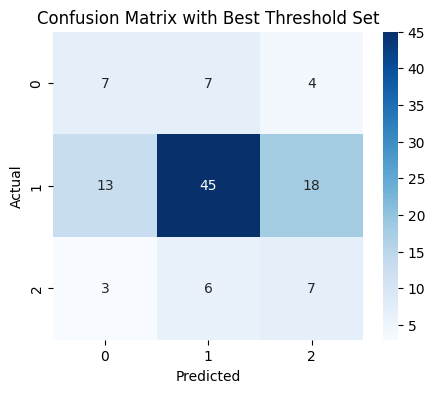

 96%|=================== | 318/330 [00:12<00:00]       

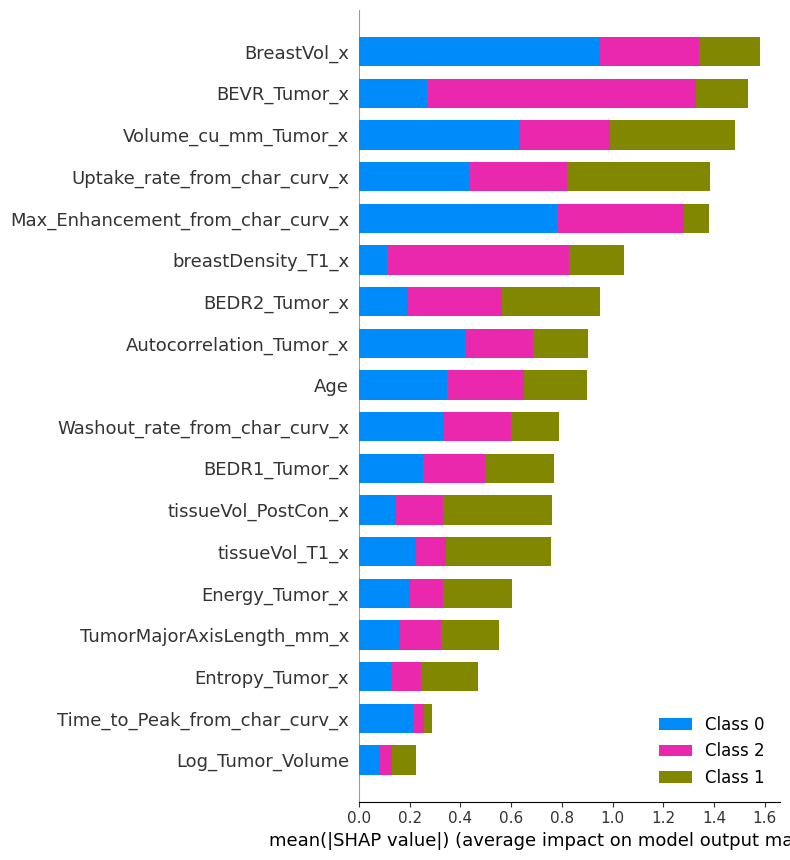

In [1]:
# Author: Lakshita Mahajan

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from lightgbm import LGBMClassifier
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import warnings
warnings.filterwarnings("ignore")

# ------------------------------
# 1️⃣ Load dataset
df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")
df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)

feature_columns = [
    'Age', 'breastDensity_T1_x', 'tissueVol_T1_x', 'tissueVol_PostCon_x', 'BreastVol_x',
    'TumorMajorAxisLength_mm_x', 'Volume_cu_mm_Tumor_x', 'Autocorrelation_Tumor_x',
    'Entropy_Tumor_x', 'Energy_Tumor_x', 'BEVR_Tumor_x', 'BEDR1_Tumor_x', 'BEDR2_Tumor_x',
    'Max_Enhancement_from_char_curv_x', 'Time_to_Peak_from_char_curv_x',
    'Uptake_rate_from_char_curv_x', 'Washout_rate_from_char_curv_x', 'Log_Tumor_Volume'
]
feature_columns = [col for col in feature_columns if col in df.columns]
X = df[feature_columns]
y = df["Tumor_Response_Encoded"]

# ------------------------------
# 2️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.35, stratify=y, random_state=42
)

# ------------------------------
# 3️⃣ Scale
qt = QuantileTransformer(output_distribution='normal', random_state=42)
X_train_scaled = qt.fit_transform(X_train)
X_test_scaled = qt.transform(X_test)
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_columns)

# ------------------------------
# 4️⃣ ADASYN balancing
adasyn = ADASYN(random_state=42)
X_train_bal, y_train_bal = adasyn.fit_resample(X_train_df, y_train)

# ------------------------------
# 5️⃣ LightGBM training
lgbm = LGBMClassifier(
    n_estimators=800,
    learning_rate=0.02,
    max_depth=6,
    num_leaves=31,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

# CV for stability check
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_acc, cv_f1 = [], []

for train_idx, val_idx in cv.split(X_train_bal, y_train_bal):
    X_tr, X_val = X_train_bal.iloc[train_idx], X_train_bal.iloc[val_idx]
    y_tr, y_val = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]
    lgbm.fit(X_tr, y_tr)
    preds = lgbm.predict(X_val)
    cv_acc.append(accuracy_score(y_val, preds))
    cv_f1.append(f1_score(y_val, preds, average='macro'))

print(f"✅ CV Accuracy: {np.mean(cv_acc):.4f} ± {np.std(cv_acc):.4f}")
print(f"✅ CV Macro F1: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")

# ------------------------------
# 6️⃣ Threshold grid search
threshold_grid = [
    [0.15, 0.7, 0.15],
    [0.20, 0.6, 0.20],
    [0.25, 0.5, 0.25],
    [0.30, 0.4, 0.30],
    [0.20, 0.5, 0.20],
]

best_result = {"accuracy": 0, "macro_f1": 0, "thresholds": None}

for thresholds in threshold_grid:
    print(f"\n🔹 Testing thresholds: {thresholds}")
    y_probs = lgbm.predict_proba(X_test_df)
    y_pred_custom = []
    for prob in y_probs:
        if prob[0] > thresholds[0]:
            y_pred_custom.append(0)
        elif prob[2] > thresholds[2]:
            y_pred_custom.append(2)
        else:
            y_pred_custom.append(1)
    y_pred_custom = np.array(y_pred_custom)

    acc = accuracy_score(y_test, y_pred_custom)
    macro_f1 = f1_score(y_test, y_pred_custom, average='macro')
    print(f"Accuracy: {acc:.4f}, Macro F1: {macro_f1:.4f}")
    print(classification_report(y_test, y_pred_custom, digits=4))

    if acc > best_result["accuracy"]:
        best_result.update({"accuracy": acc, "macro_f1": macro_f1, "thresholds": thresholds})

print("\n✅ Best Threshold Set:", best_result["thresholds"])
print(f"✅ Best Accuracy: {best_result['accuracy']:.4f}")
print(f"✅ Best Macro F1: {best_result['macro_f1']:.4f}")

# ------------------------------
# 7️⃣ Final Confusion Matrix
y_probs = lgbm.predict_proba(X_test_df)
y_pred_final = []
for prob in y_probs:
    if prob[0] > best_result["thresholds"][0]:
        y_pred_final.append(0)
    elif prob[2] > best_result["thresholds"][2]:
        y_pred_final.append(2)
    else:
        y_pred_final.append(1)
y_pred_final = np.array(y_pred_final)

plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_final), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix with Best Threshold Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ------------------------------
# 🔟 SHAP Interpretability
explainer = shap.Explainer(lgbm, X_train_bal)
shap_values = explainer(X_test_df)
shap.summary_plot(shap_values, X_test_df, feature_names=feature_columns)

In [2]:
# Author: Lakshita Mahajan

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

# ------------------------------
# 1️⃣ Prepare and align data for fairness evaluation
df_preds = pd.DataFrame({
    "Patient_ID_Num": df.loc[X_test.index, "Patient_ID_Num"].values,
    "True_Label": y_test.values,
    "Pred_LGBM_Tuned": y_pred_final
})

# Load sensitive attributes for merging
df_sensitive = df[["Patient_ID_Num", "Age"]].copy()

# Add additional sensitive attributes if available
for col in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 5", "Unnamed: 20", "Unnamed: 21"]:
    if col in df.columns:
        df_sensitive[col] = df[col]

# Rename for clarity
df_sensitive = df_sensitive.rename(columns={
    "Unnamed: 2": "Manufacturer",
    "Unnamed: 3": "Manufacturer_Model",
    "Unnamed: 5": "Field_Strength",
    "Unnamed: 20": "Menopausal_Status",
    "Unnamed: 21": "Race"
})

# Compute Age Groups
df_sensitive["Age_Years"] = df_sensitive["Age"] * 10
df_sensitive["Age_Group"] = pd.cut(
    df_sensitive["Age_Years"],
    bins=[0, 49, 64, 150],
    labels=["Young", "Middle", "Older"]
)

# Merge predictions with sensitive attributes
df_eval = df_preds.merge(df_sensitive, on="Patient_ID_Num", how="left").dropna()

# ------------------------------
# 2️⃣ Create new results folder for this model
os.makedirs("../results_lgbm_tuned/", exist_ok=True)

# ------------------------------
# 3️⃣ Compute metrics across groups
def compute_subgroup_metrics(df, group_col):
    metrics = []
    for group in sorted(df[group_col].dropna().unique()):
        subset = df[df[group_col] == group]
        y_true = subset["True_Label"]
        y_pred = subset["Pred_LGBM_Tuned"]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        try:
            roc = roc_auc_score(y_true, pd.get_dummies(y_pred), multi_class='ovo')
        except:
            roc = np.nan

        metrics.append({
            "Group": group,
            "N": len(subset),
            "Accuracy": acc,
            "F1_macro": f1,
            "ROC_AUC_OVO": roc
        })
    return pd.DataFrame(metrics)

# Evaluate across dimensions
for dim in ["Race", "Menopausal_Status", "Manufacturer", "Manufacturer_Model", "Field_Strength", "Age_Group"]:
    if dim in df_eval.columns:
        metrics_df = compute_subgroup_metrics(df_eval, dim)
        print(f"\nFairness Evaluation Across {dim}")
        print(metrics_df)
        metrics_df.to_csv(f"../results_lgbm_tuned/metrics_{dim}.csv", index=False)

print("\n✅ Fairness evaluation completed and saved in '../results_lgbm_tuned/' for MedFair and structured comparison.")


Fairness Evaluation Across Race
   Group   N  Accuracy  F1_macro  ROC_AUC_OVO
0      0   1  1.000000  1.000000          NaN
1      1  67  0.507463  0.427350     0.593056
2      2  36  0.527778  0.352986     0.519907
3      3   2  0.500000  0.333333          NaN
4      4   1  1.000000  1.000000          NaN
5      5   2  1.000000  1.000000          NaN
6      6   1  1.000000  1.000000          NaN

Fairness Evaluation Across Menopausal_Status
   Group   N  Accuracy  F1_macro  ROC_AUC_OVO
0      0  59  0.542373  0.496970     0.652047
1      1  51  0.529412  0.353871     0.520990

Fairness Evaluation Across Manufacturer
   Group   N  Accuracy  F1_macro  ROC_AUC_OVO
0      0  67  0.477612  0.350003     0.517354
1      2  43  0.627907  0.568485     0.726601

Fairness Evaluation Across Manufacturer_Model
   Group   N  Accuracy  F1_macro  ROC_AUC_OVO
0      0  26  0.653846  0.613095     0.847222
1      1   6  0.333333  0.166667          NaN
2      2   1  0.000000  0.000000          NaN
3    

# FAIRNESS CALCULATION


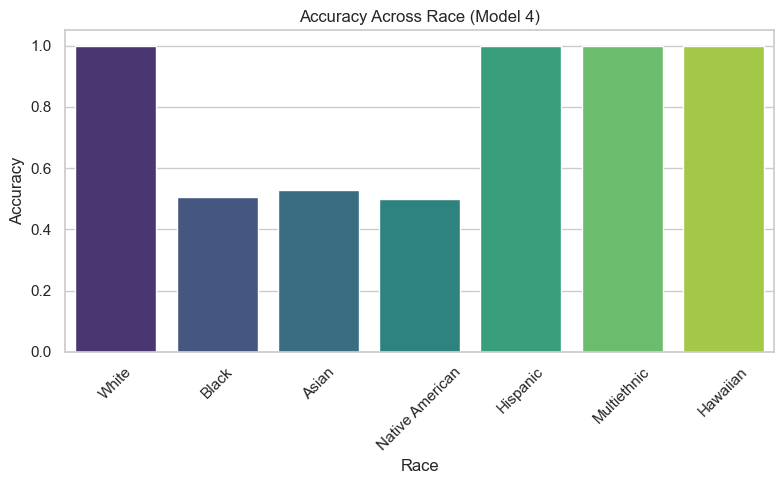

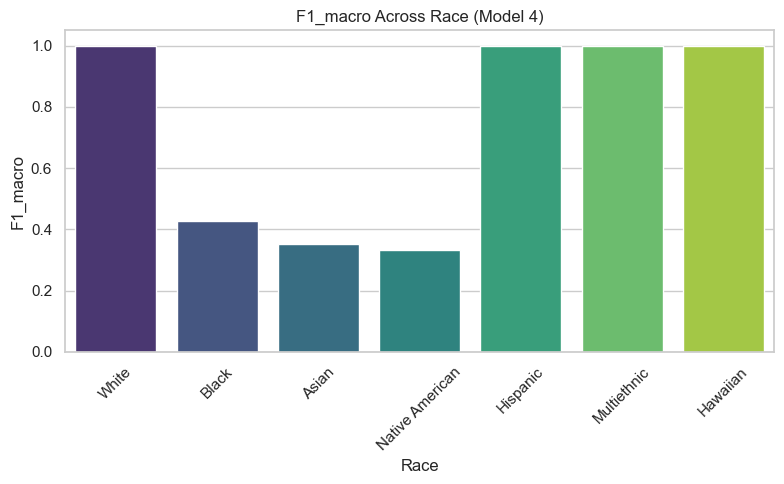

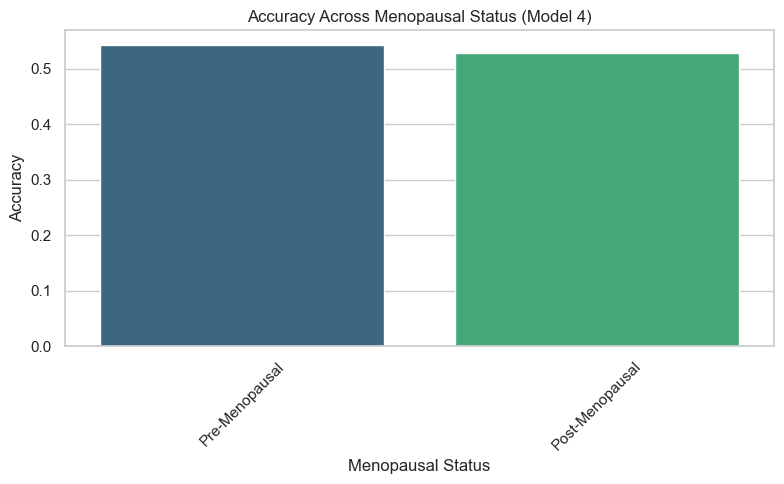

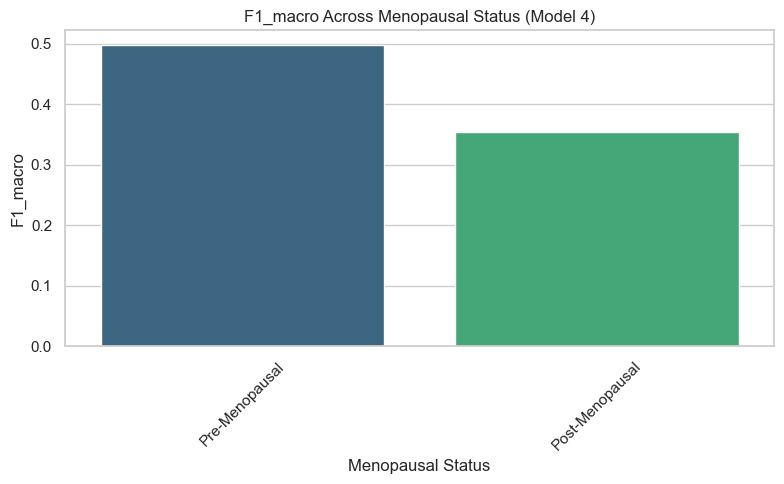

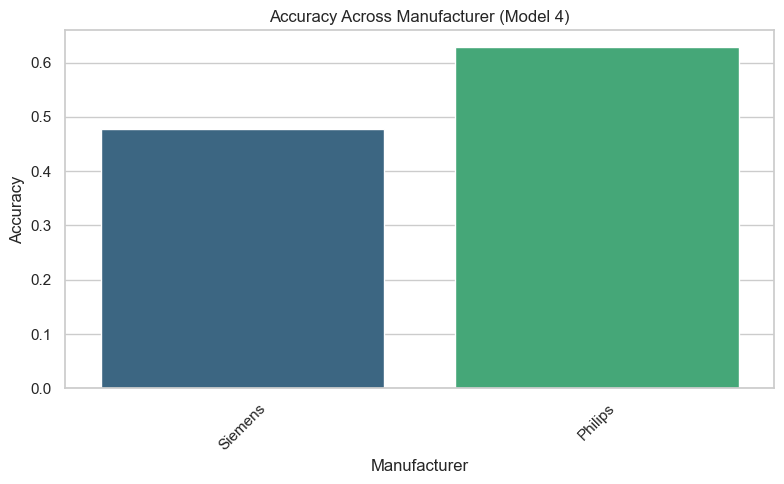

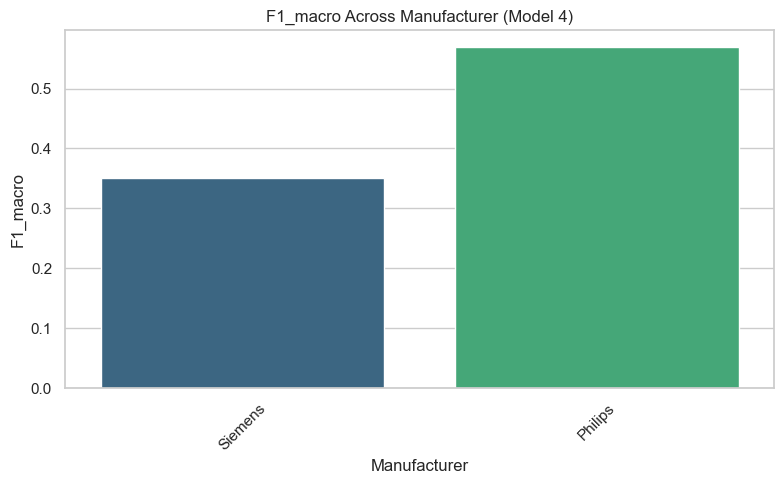

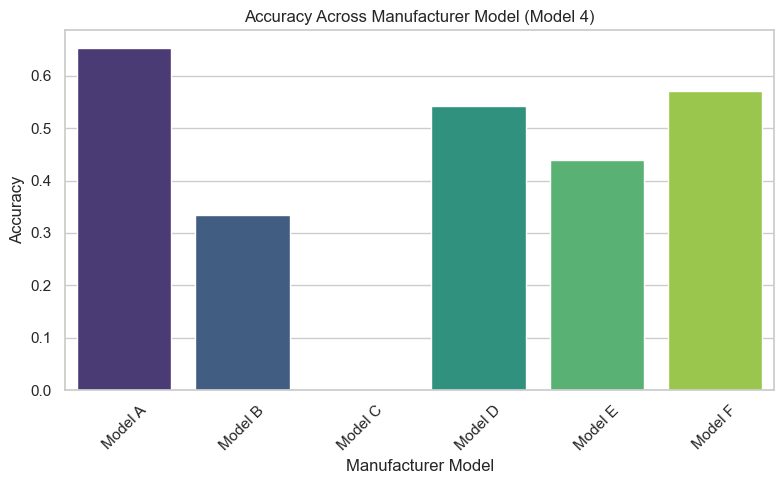

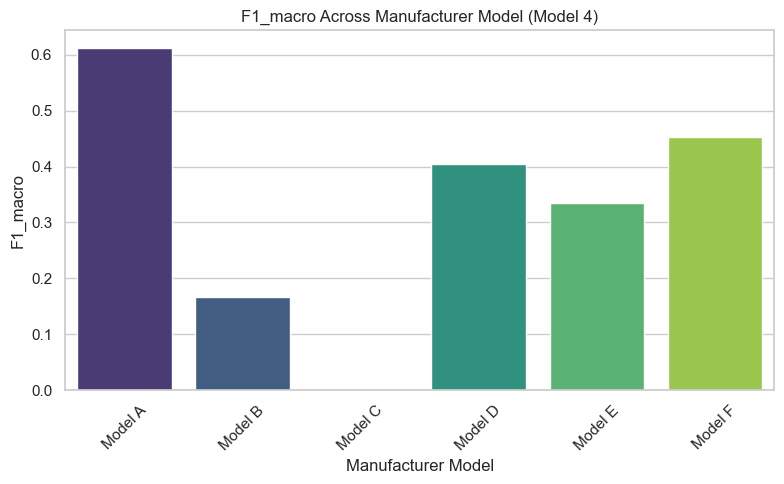

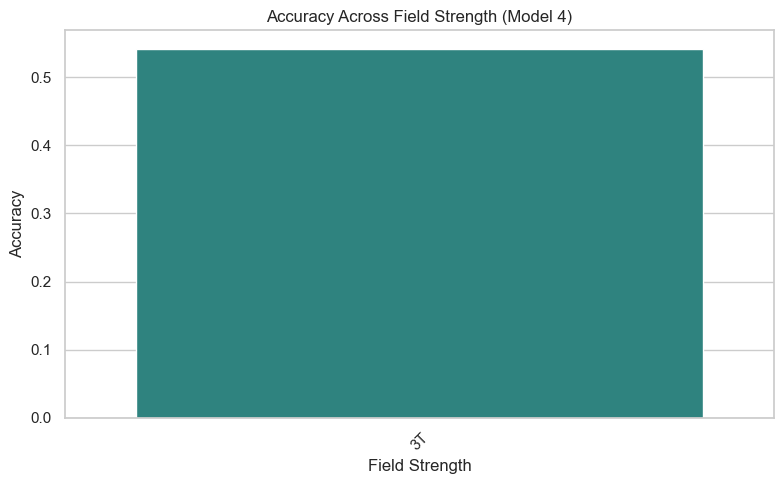

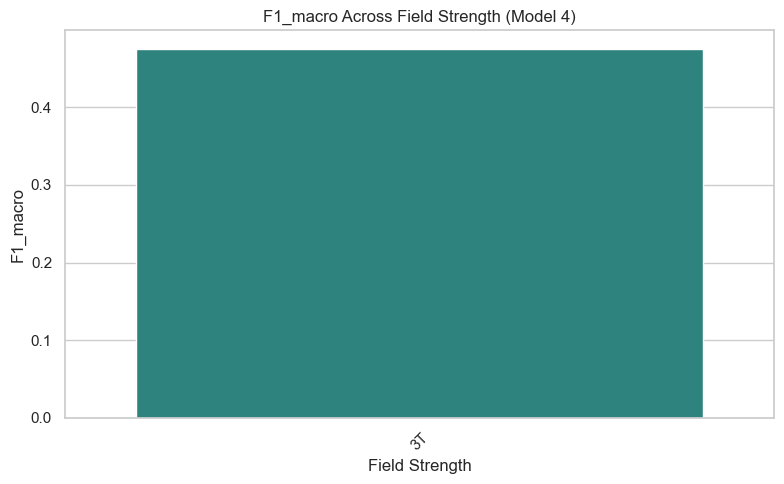

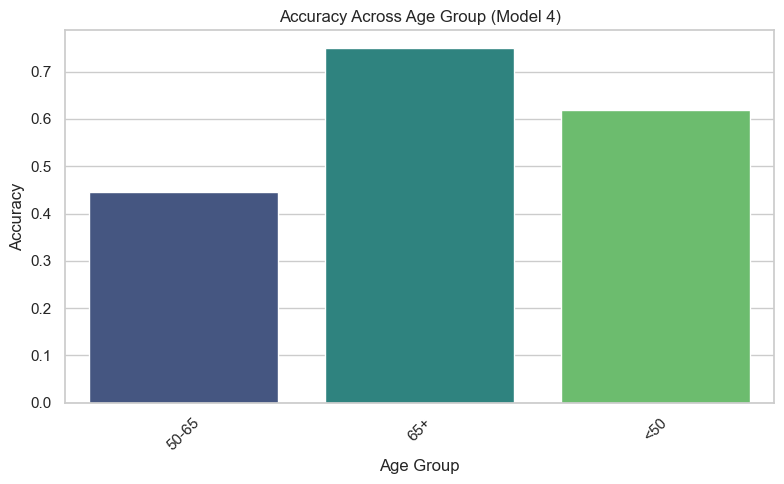

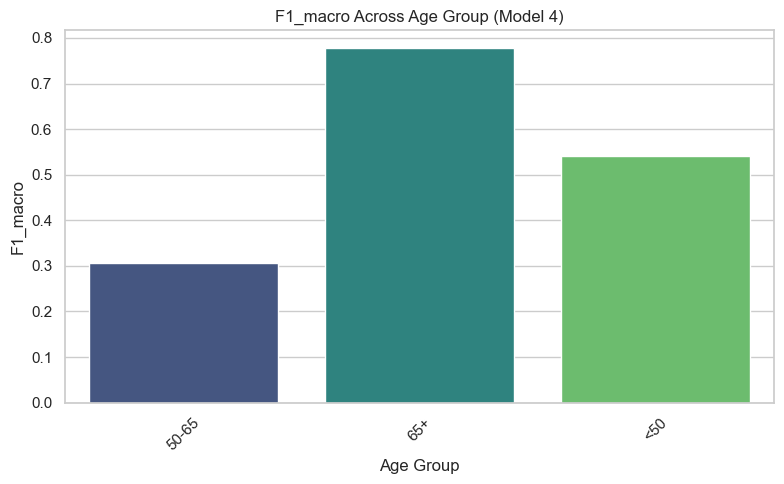

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for clarity
sns.set(style="whitegrid")

# -------------------------
# 1️⃣ Define mapping dictionaries
race_mapping = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Native American',
    4: 'Hispanic',
    5: 'Multiethnic',
    6: 'Hawaiian'
}

menopause_mapping = {
    0: 'Pre-Menopausal',
    1: 'Post-Menopausal'
}

manufacturer_mapping = {
    0: 'Siemens',
    1: 'GE',
    2: 'Philips'
}

# Add additional mappings if available in your data:
manufacturer_model_mapping = {
    0: 'Model A',
    1: 'Model B',
    2: 'Model C',
    3: 'Model D',
    4: 'Model E',
    5: 'Model F',
    6: 'Model G'
}

field_strength_mapping = {
    0: '1.5T',
    1: '3T'
}

age_group_mapping = {
    'Young': '<50',
    'Middle': '50-65',
    'Older': '65+'
}

# -------------------------
# 2️⃣ Helper plotting function

def plot_fairness_metric(csv_path, group_col, mapping=None, metric_col='Accuracy', save_name='plot.png'):
    df = pd.read_csv(csv_path)
    df = df.sort_values(by='Group')

    if mapping:
        df['Group_Label'] = df['Group'].map(mapping)
    else:
        df['Group_Label'] = df['Group'].astype(str)

    plt.figure(figsize=(8, 5))
    sns.barplot(x='Group_Label', y=metric_col, data=df, palette='viridis')
    plt.title(f"{metric_col} Across {group_col} (Model 4)")
    plt.xlabel(group_col)
    plt.ylabel(metric_col)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(save_name, dpi=300)
    plt.show()

# -------------------------
# 3️⃣ Generate plots (edit paths as needed)

# Race
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Race.csv",
    group_col="Race",
    mapping=race_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/race_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Race.csv",
    group_col="Race",
    mapping=race_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/race_macro_f1.png"
)

# Menopausal Status
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Menopausal_Status.csv",
    group_col="Menopausal Status",
    mapping=menopause_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/menopause_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Menopausal_Status.csv",
    group_col="Menopausal Status",
    mapping=menopause_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/menopause_macro_f1.png"
)

# Manufacturer
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer.csv",
    group_col="Manufacturer",
    mapping=manufacturer_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/manufacturer_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer.csv",
    group_col="Manufacturer",
    mapping=manufacturer_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/manufacturer_macro_f1.png"
)

# Manufacturer Model
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer_Model.csv",
    group_col="Manufacturer Model",
    mapping=manufacturer_model_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/manufacturer_model_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Manufacturer_Model.csv",
    group_col="Manufacturer Model",
    mapping=manufacturer_model_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/manufacturer_model_macro_f1.png"
)

# Field Strength
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Field_Strength.csv",
    group_col="Field Strength",
    mapping=field_strength_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/field_strength_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Field_Strength.csv",
    group_col="Field Strength",
    mapping=field_strength_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/field_strength_macro_f1.png"
)

# Age Group
plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Age_Group.csv",
    group_col="Age Group",
    mapping=age_group_mapping,
    metric_col="Accuracy",
    save_name="../results_lgbm_tuned/Plots/age_group_accuracy.png"
)

plot_fairness_metric(
    csv_path="../results_lgbm_tuned/metrics_Age_Group.csv",
    group_col="Age Group",
    mapping=age_group_mapping,
    metric_col="F1_macro",
    save_name="../results_lgbm_tuned/Plots/age_group_macro_f1.png"
)



In [11]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os

# Load enriched data
df = pd.read_csv("../data/processed/cleaned_clinical_enriched.csv")

# Ensure Patient_ID_Num exists for merging
df["Patient_ID_Num"] = df["Patient ID"].astype(str).str.extract(r"(\d+)$").astype(int)

# Create predictions DataFrame (adjust y_test and y_pred accordingly)
df_preds = pd.DataFrame({
    "Patient_ID_Num": df.loc[X_test.index, "Patient_ID_Num"].values,
    "True_Label": y_test.values,
    "Pred_LGBM_Tuned": y_pred_final  # Replace this with your final model predictions
})

# Select sensitive attributes and rename
df_sensitive = df[[
    "Patient_ID_Num", "Age",
    "Unnamed: 2", "Unnamed: 3", "Unnamed: 5", "Unnamed: 20", "Unnamed: 21"
]].copy()

df_sensitive = df_sensitive.rename(columns={
    "Unnamed: 2": "Manufacturer",
    "Unnamed: 3": "Manufacturer_Model",
    "Unnamed: 5": "Field_Strength",
    "Unnamed: 20": "Menopausal_Status",
    "Unnamed: 21": "Race"
})

# Compute Age Group
df_sensitive["Age_Years"] = df_sensitive["Age"] * 10
df_sensitive["Age_Group"] = pd.cut(
    df_sensitive["Age_Years"],
    bins=[0, 49, 64, 150],
    labels=["Young", "Middle", "Older"]
)

# Merge for fairness evaluation
df_eval = df_preds.merge(df_sensitive, on="Patient_ID_Num", how="left").dropna()

# Save for reuse
os.makedirs("../results_lgbm_tuned/", exist_ok=True)
df_eval.to_csv("../results_lgbm_tuned/df_eval_model4.csv", index=False)

# Define fairness metrics by group
def compute_fairness_metrics(df, group_col):
    results = []
    for group in sorted(df[group_col].dropna().unique()):
        subset = df[df[group_col] == group]
        y_true = subset["True_Label"]
        y_pred = subset["Pred_LGBM_Tuned"]

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='macro')
        try:
            roc = roc_auc_score(y_true, pd.get_dummies(y_pred), multi_class='ovo')
        except:
            roc = np.nan

        results.append({
            "Group Parameter": group_col,
            "Group": group,
            "N": len(subset),
            "Accuracy": acc,
            "Macro F1": f1,
            "ROC AUC OVO": roc
        })

    return pd.DataFrame(results)

# Evaluate fairness for each parameter
for col in ["Race", "Menopausal_Status", "Manufacturer", "Manufacturer_Model", "Field_Strength", "Age_Group"]:
    fairness_table = compute_fairness_metrics(df_eval, col)
    print(f"\nFairness Evaluation by {col}")
    print(fairness_table)
    fairness_table.to_csv(f"../results_lgbm_tuned/fairness_{col}.csv", index=False)



Fairness Evaluation by Race
  Group Parameter  Group   N  Accuracy  Macro F1  ROC AUC OVO
0            Race      0   1  1.000000  1.000000          NaN
1            Race      1  67  0.507463  0.427350     0.593056
2            Race      2  36  0.527778  0.352986     0.519907
3            Race      3   2  0.500000  0.333333          NaN
4            Race      4   1  1.000000  1.000000          NaN
5            Race      5   2  1.000000  1.000000          NaN
6            Race      6   1  1.000000  1.000000          NaN

Fairness Evaluation by Menopausal_Status
     Group Parameter  Group   N  Accuracy  Macro F1  ROC AUC OVO
0  Menopausal_Status      0  59  0.542373  0.496970     0.652047
1  Menopausal_Status      1  51  0.529412  0.353871     0.520990

Fairness Evaluation by Manufacturer
  Group Parameter  Group   N  Accuracy  Macro F1  ROC AUC OVO
0    Manufacturer      0  67  0.477612  0.350003     0.517354
1    Manufacturer      2  43  0.627907  0.568485     0.726601

Fairness Evalu

100%|===================| 329/330 [00:12<00:00]        

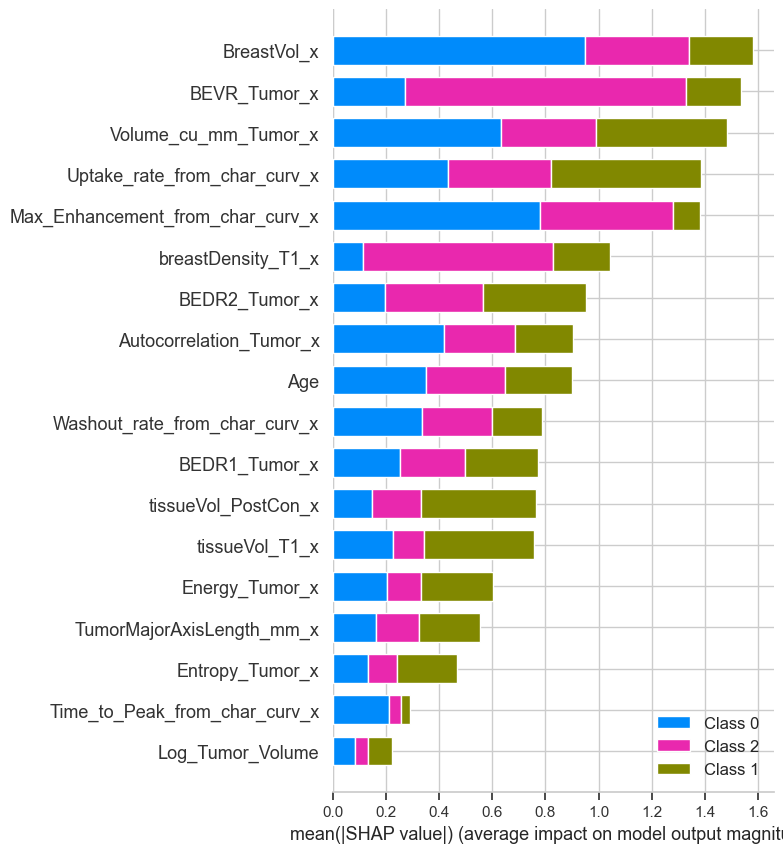

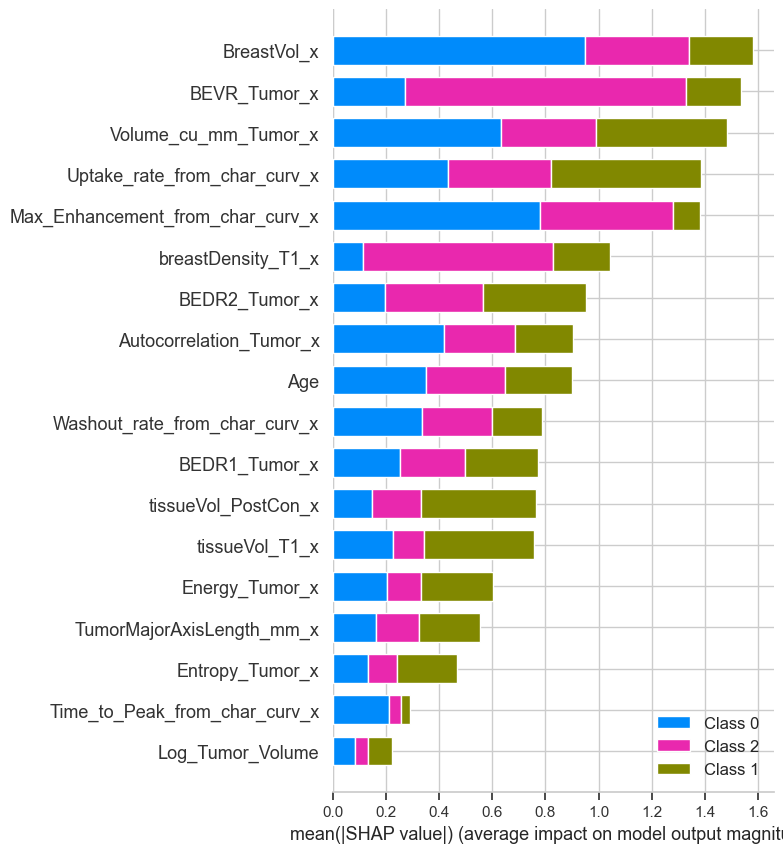

In [12]:
import shap
import matplotlib.pyplot as plt

# ✅ Use the trained LightGBM model (lgbm), and balanced training set
# Make sure: lgbm, X_train_bal, X_test_df, feature_columns are already defined

# Create SHAP explainer
explainer = shap.Explainer(lgbm, X_train_bal)

# Compute SHAP values on test data
shap_values = explainer(X_test_df)

# ✅ Beeswarm Plot — shows full feature impact for all classes
shap.summary_plot(shap_values, X_test_df, feature_names=feature_columns)

# ✅ Bar Plot — shows mean absolute SHAP values for top contributing features
shap.summary_plot(shap_values, X_test_df, feature_names=feature_columns, plot_type="bar")


 97%|=================== | 321/330 [00:12<00:00]       

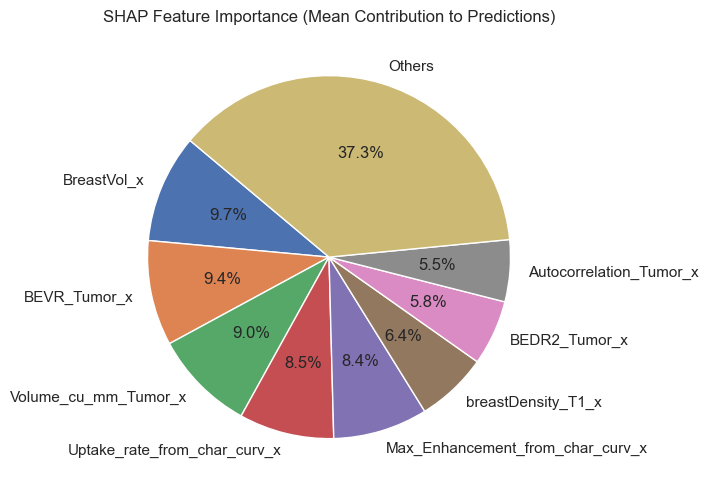

In [13]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Run SHAP explainer
explainer = shap.Explainer(lgbm, X_train_bal)
shap_values = explainer(X_test_df)

# Multiclass fix: average across classes
# shap_values.values.shape → (n_samples, n_features, n_classes)
# Take mean absolute SHAP across samples and classes
shap_vals_abs = np.abs(shap_values.values).mean(axis=(0, 2))  # 1D array

# Build importance DataFrame
shap_importance = pd.DataFrame({
    "Feature": feature_columns,
    "Mean_SHAP": shap_vals_abs
}).sort_values("Mean_SHAP", ascending=False)

# Top N + "Others"
top_n = 8
shap_top = shap_importance.head(top_n)
other_total = shap_importance["Mean_SHAP"][top_n:].sum()
shap_top = pd.concat([
    shap_top,
    pd.DataFrame({"Feature": ["Others"], "Mean_SHAP": [other_total]})
], ignore_index=True)

# ✅ Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(shap_top["Mean_SHAP"], labels=shap_top["Feature"], autopct="%1.1f%%", startangle=140)
plt.title("SHAP Feature Importance (Mean Contribution to Predictions)")
plt.tight_layout()
plt.show()


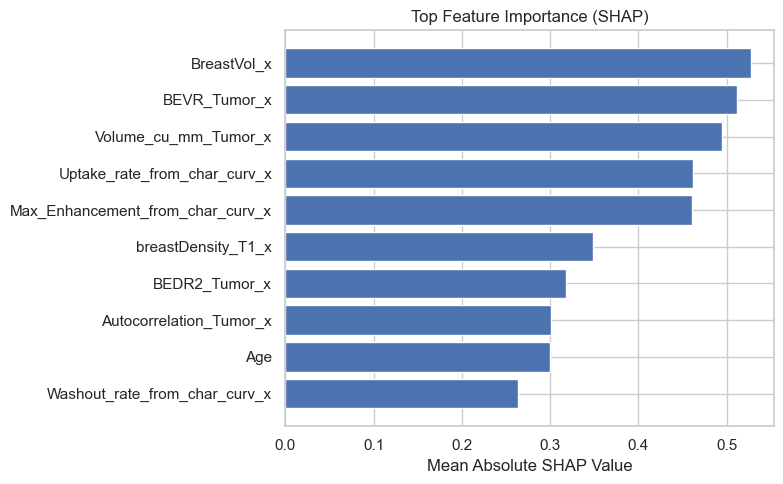

In [14]:
# Use top N features
top_n = 10
shap_top = shap_importance.head(top_n)

# Plot
plt.figure(figsize=(8, 5))
plt.barh(shap_top["Feature"][::-1], shap_top["Mean_SHAP"][::-1])
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Top Feature Importance (SHAP)")
plt.tight_layout()
plt.show()
